In [1]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.appName('Customers').getOrCreate()
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
def bin2dec(x,th):
    dec=0;
    for i in range(0,4):
        dec=dec+x[3-i]*pow(2,i)
    if (dec>th):
        dec=th
    if (dec<2):
        dec=2
    return dec 

def selectedfeat(ga,th):
    a=[]
    for i in range(0,len(ga)-4):
        if (ga[i]==1):
            fn="_c" + str(i)
            a.append(fn)
    dec=bin2dec(ga[-4:],th)    
#     print(a)
#     print(dec)
    return a,dec

In [3]:
import random
def crossover(x,pc):
    noc=pc*np.shape(x)[0]
    if(noc%2!=0):
        noc=noc+1 
    a=random.sample(range(1, np.shape(x)[0]), int(noc))
    bp=int(np.shape(x)[1]/2)
    x1=np.zeros((int(noc/2),np.shape(x)[1]))
    for i in range(0,int(noc/2)):
        a1=a[2*i]
        a2=a[2*i+1]
        c1=x[a1,:]
        c2=x[a2,:]
        x1[i,0:bp]=c1[0:bp]
        x1[i,bp+1:]=c2[bp+1:]
    return x1 

In [4]:
def mutation(x,pm):
    noc=int(pm*np.shape(x)[1])
    a=np.random.randint(np.shape(x)[1], size=(np.shape(x)[0], noc))
    for i in range(0,np.shape(x)[0]):
        a1=a[i,:]
        for j in range(0,noc):
            if (x[i,a1[j]]==0):
                x[i,a1[j]]=1
            else:
                x[i,a1[j]]=0
    return x 

In [5]:
def makedata(ga,data,th):
    dataf=[]
    for row in ga:
        d=[]
        a,dec=selectedfeat(row,th)
        featureassembler=VectorAssembler(inputCols=a,outputCol="features")
        dataset=featureassembler.transform(data)
        d.append(dataset)
        d.append(dec)
        dataf.append(d)
    return dataf

In [6]:
def fitnessvaluega1(dataset1):
    dataset=dataset1[0]
    k=dataset1[1]
    dataset=dataset.select('features')
    dataset.rdd.collect()
    kmeans = KMeans().setK(int(k)).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    return silhouette

In [7]:
import multiprocess 
import time 

In [8]:
# noc=input("Enter number of chromosome")
# noc=int(noc)
# th=input("Enter max threshold")
# th=int(th)
# wn=input("Enter number of working node")
# wn=int(wn)
# nog=input("Enter number of Generations")
# nog=int(nog)
noc =25
th = 0.5
wn = 4
nog = 20

In [9]:
from multiprocess.pool import ThreadPool 
pool=ThreadPool(wn)


In [10]:
import time
befit=-1
pc=0.5
pm=0.1
dataset_path='Dataset/'
bsv=[]
timef=[]
befs=[]
for j in range(0,3):
    if j!=4 and j!=5:
        fname= dataset_path+str(j+1) +'.csv'
        print('\nIn Progress: '+str(j+1)+'.csv'+'\n')
        dataset=spark.read.csv(fname,inferSchema=True,header=False)
        columns = len(dataset.columns)
        rows=dataset.count()
        print(rows,columns)
        ga=np.random.randint(2, size=(noc, columns+4))
        dataf=makedata(ga,dataset,th)
        iterbest=np.zeros((nog))
        tf=np.zeros((nog))

        for gno in range(0,nog):
            print(gno)
            start = time.time()
            s=np.zeros((noc))
            s=pool.map(fitnessvaluega1,dataf)
            maxs=np.max(s)
            maxi=np.argmax(s)  
            if maxs>befit:
                befit=maxs
                gaf=ga[maxi,:]
            iterbest[gno]=befit    
            ga=crossover(ga,pc)
            ga=mutation(ga,pm)
            nr=np.shape(ga)[0]   
            ga=np.concatenate((ga,np.random.randint(2, size=(noc-nr, columns+4))), axis=0)
            print(befit,gno)
            dataf=makedata(ga,dataset,th)
            end = time.time()
            tf[gno]=end-start
        bsv.append(iterbest)
        timef.append(tf)
        befs.append(befit)


In Progress: 1.csv

26509 100
0
0.30276573386371164 0
1
0.30276573386371164 1
2
0.30880707168818494 2
3
0.30880707168818494 3
4
0.318583110643518 4
5
0.318583110643518 5
6
0.318583110643518 6
7
0.318583110643518 7
8
0.318583110643518 8
9
0.318583110643518 9
10
0.318583110643518 10
11
0.318583110643518 11
12
0.318583110643518 12
13
0.318583110643518 13
14
0.318583110643518 14
15
0.318583110643518 15
16
0.318583110643518 16
17
0.318583110643518 17
18
0.318583110643518 18
19
0.318583110643518 19

In Progress: 2.csv

26509 100
0
0.5355304062623758 0
1
0.5512013119427602 1
2
0.5512013119427602 2
3
0.5512013119427602 3
4
0.5512013119427602 4
5
0.5512013119427602 5
6
0.5512013119427602 6
7
0.5512013119427602 7
8
0.5512013119427602 8
9
0.5512013119427602 9
10
0.5512013119427602 10
11
0.5512013119427602 11
12
0.5512013119427602 12
13
0.5512013119427602 13
14
0.5512013119427602 14
15
0.5512013119427602 15
16
0.5512013119427602 16
17
0.5512013119427602 17
18
0.5521377090054623 18
19
0.5521377090

In [11]:
bsv

[array([0.30276573, 0.30276573, 0.30880707, 0.30880707, 0.31858311,
        0.31858311, 0.31858311, 0.31858311, 0.31858311, 0.31858311,
        0.31858311, 0.31858311, 0.31858311, 0.31858311, 0.31858311,
        0.31858311, 0.31858311, 0.31858311, 0.31858311, 0.31858311]),
 array([0.53553041, 0.55120131, 0.55120131, 0.55120131, 0.55120131,
        0.55120131, 0.55120131, 0.55120131, 0.55120131, 0.55120131,
        0.55120131, 0.55120131, 0.55120131, 0.55120131, 0.55120131,
        0.55120131, 0.55120131, 0.55120131, 0.55213771, 0.55213771]),
 array([0.55213771, 0.55213771, 0.55213771, 0.55213771, 0.55213771,
        0.55213771, 0.55213771, 0.55213771, 0.55213771, 0.55213771,
        0.55213771, 0.55213771, 0.55213771, 0.55213771, 0.55213771,
        0.55213771, 0.55213771, 0.55213771, 0.55213771, 0.55213771])]

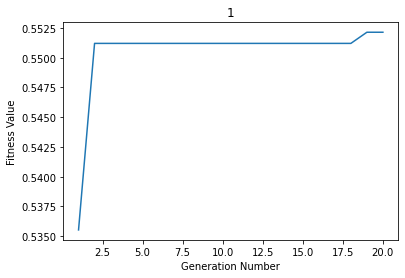

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [17]:
gnof=np.zeros(nog)
for i in range(0,nog):
    gnof[i]=i+1
import matplotlib.pyplot as plt 
plt.plot(gnof,bsv[1])
plt.xlabel('Generation Number') 
plt.ylabel('Fitness Value')  
plt.title('1') 
plt.show() 
plt.savefig

# plt.plot(gnof,bsv[1])
# plt.xlabel('Generation Number') 
# plt.ylabel('Fitness Value')  
# plt.title('Skg') 
# plt.show() 


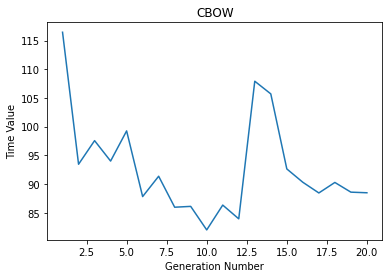

In [18]:
plt.plot(gnof,timef[0])
plt.xlabel('Generation Number') 
plt.ylabel('Time Value')  
plt.title('CBOW') 
plt.show() 




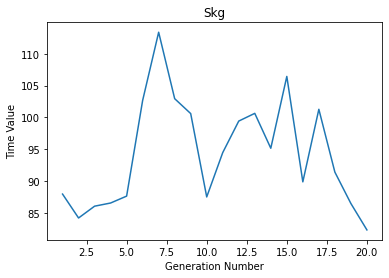

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(gnof,timef[1])
plt.xlabel('Generation Number') 
plt.ylabel('Time Value')  
plt.title('Skg') 
plt.show() 
plt.savefig('timeskg_20.png')